In [1467]:
from collections import Counter
import inspect
import json
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch
from torch import nn, optim
# Professional optimization for GPU training
from torch.amp import GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryPrecision, BinaryRecall
import yaml

In [1468]:
print('Cuda is available' if torch.cuda.is_available() else "Cuda isn't avaialable")

Cuda is available


In [1469]:
class Config:
    
    PAD_TOKEN = '<PAD>'
    UNK_TOKEN = '<UNK>'
    PAD_IDX = 0
    UNK_IDX = 1
    BATCH_SIZE = 128
    DROP_LOCATION = True
    NUM_LSTM_LAYERS = 2
    HIDDEN_DIM = 64
    DROPOUT = 0.28
    OUTPUT_DIM = 1
    EMB_DIM = 100
    EPOCHS = 50
    LEARNING_RATE = 3e-4
    LOWERCASE = True
    MAX_LENGTH = 200
    SEED = 28
    STRIP_MULTIPLE_WHITESPACE = True
    TRAIN_TEST_SPLIT = 0.8
    USE_KEYWORD = True
    UPPERCASE = False
    VOCAB_SIZE = 10000
    NUM_WORKERS = 0
    METRIC_THRESHOLD = 0.5
    INFERENCE_THRESHOLD = 0.5
    EARLY_STOP_PATIENCE = 5
    EARLY_STOP_MIN_DELTA = 1e-3
    ARTIFACT_DIR = './artifacts/'
    IMAGE_DIR = './images/'
    DATA_DIR = './data/'
    CHECKPOINT_PATH = './model/'
    EMB_PATH = os.path.join(DATA_DIR, "glove.6B.100d.txt")
    TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
    TEST_PATH = os.path.join(DATA_DIR, 'test.csv')
    

    @staticmethod
    def get_device():
        '''
        Detects the best available device for PyTorch.
        Priority: TPU -> GPU (CUDA) -> CPU
        '''
        # 1. Check for TPU (requires torch_xla)
        try:
            import torch_xla.core.xla_model as xm
            device = xm.xla_device()
            print(f"Using TPU: {device}")
        except ImportError:
            # 2. Check for GPU (CUDA)
            if torch.cuda.is_available():
                device = torch.device("cuda")
                print(f"Using GPU: {torch.cuda.get_device_name(0)}")
            # 3. Fallback to CPU
            else:
                device = torch.device("cpu")
                print("Using CPU")
                
        return device
    DEVICE = get_device.__func__()

    @classmethod
    def to_dict(cls):
        return {
            k: v for k, v in cls.__dict__.items()
            if not k.startswith("_")
            and not inspect.isroutine(v)   # functions, methods
            and not isinstance(v, (classmethod, staticmethod))
        }

Using GPU: NVIDIA GeForce GTX 1650


In [1470]:
for path in [Config.EMB_PATH, Config.TRAIN_PATH, Config.TEST_PATH]:
    assert os.path.exists(path), f"File not found: {path}"

In [1471]:
def seed_everything(seed, deterministic=False):
    '''
    Ensures absolute reproducibility.
    '''
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    if deterministic:
        # Only use these for the final "Gold" run to ensure exact results
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        print("Using STRICT Deterministic mode (Slower).")
    else:
        # Benchmark=True allows cuDNN to find the fastest kernels for your hardware
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True
        print("Using PROTOTYPING mode (Faster).")
    print(f"For Reproducibility, Everything seeded with {seed}!")



In [1472]:
cfg = Config()
seed_everything(cfg.SEED, deterministic=False)
print(f"Training on: {cfg.DEVICE} with seed = {cfg.SEED}")

Using PROTOTYPING mode (Faster).
For Reproducibility, Everything seeded with 28!
Training on: cuda with seed = 28


In [1473]:
# This will be used in the training loop later
scaler = GradScaler(device=cfg.DEVICE.type, enabled=(cfg.DEVICE.type == 'cuda'))

In [1474]:
df = pd.read_csv(cfg.TRAIN_PATH)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [1475]:
def clean_text(text, config=cfg):
    '''
    Professional cleaning for Deep Learning:
    - Removes URLs and HTML tags
    - Standardizes whitespace
    - Keeps punctuation and stopwords for context
    '''
    if config.LOWERCASE:
        # Lowercase
        text = text.lower()
    elif config.UPPERCASE:
        text = text.upper()
    
    # URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' <URL> ', text)

    # HTML entities
    text = re.sub(r'&amp;', ' and ', text)

    # Mentions
    text = re.sub(r'@\w+', ' <USER> ', text)

    # Split URL-style joined words (general)
    text = re.sub(r'%20', ' ', text)


    # Remove broken unicode artifacts
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Normalize repeated punctuation
    text = re.sub(r'!{2,}', ' !! ', text)
    text = re.sub(r'\?{2,}', ' ?? ', text)

    if config.STRIP_MULTIPLE_WHITESPACE:    
        # Normalize whitespace
        text = re.sub(r'\s+', ' ', text).strip()

    # Normalize numbers
    text = re.sub(r'\b\d+\b', ' <NUM> ', text)

    # Reduce elongated words: cooool -> cool
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    text = re.sub(r'#\s+(\w+)', r'#\1', text)


    return text

In [1476]:
def final_text_with_keyword(row, config=cfg):
    keyword = str(row["keyword"]).strip() if pd.notna(row["keyword"]) else ""
    keyword = clean_text(keyword, config)
    cleaned_text = clean_text(row["text"], config)

    if config.USE_KEYWORD and keyword != "":
        return f"{keyword} : {cleaned_text}"

    return cleaned_text

In [1477]:
def preprocess_df(df, config=cfg):
    if config.DROP_LOCATION and 'location' in df.columns:
        df = df.drop(columns=['location'])

    df['final_text'] = df.apply(final_text_with_keyword, axis=1)
    df = df.drop(columns=['keyword', 'text'])

    return df

In [1478]:
df = preprocess_df(df, config=cfg)
df.head()

,id,target,final_text
0,1,1,our deeds are the reason of this #earthquake m...
1,4,1,forest fire near la ronge sask. canada
2,5,1,all residents asked to 'shelter in place' are ...
3,6,1,"<NUM> , <NUM> people receive #wildfires evac..."
4,7,1,just got sent this photo from ruby #alaska as ...


In [1479]:
df.isna().sum()

id            0
target        0
final_text    0
dtype: int64

In [1480]:
df_train, df_val = train_test_split(
    df, train_size=cfg.TRAIN_TEST_SPLIT, random_state=cfg.SEED, shuffle=True
)

In [1481]:
def build_vocab(texts, config=cfg):
    counter = Counter()
    vocab_size = config.VOCAB_SIZE
    PAD_TOKEN = config.PAD_TOKEN
    PAD_IDX = config.PAD_IDX
    UNK_TOKEN = config.UNK_TOKEN
    UNK_IDX = config.UNK_IDX
    for text in texts:
        tokens = text.split()
        counter.update(tokens)

    most_common = counter.most_common(vocab_size - 2)

    vocab = {
        PAD_TOKEN: PAD_IDX,
        UNK_TOKEN: UNK_IDX
    }

    for idx, (word, _) in enumerate(most_common, start=2):
        vocab[word] = idx

    return vocab


In [1482]:
vocab = build_vocab(df_train["final_text"], cfg)
vocab_size = len(vocab)
print("Vocab size:", vocab_size)

Vocab size: 10000


In [1483]:
def save_vocabs(stoi: dict, path: str):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)

    itos = {str(v): k for k, v in stoi.items()}
    payload = {
        "vocab_size": len(stoi),
        "special_tokens": {
            "pad": "<PAD>",
            "unk": "<UNK>"
        },
        "stoi": stoi,
        "itos": itos
    }
    with open(path, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)

    print("Vocab and inverse Vocab saved as a JSON file")

In [1484]:
save_vocab_path = os.path.join(cfg.ARTIFACT_DIR, "vocabs.json")
save_vocabs(vocab, save_vocab_path)

Vocab and inverse Vocab saved as a JSON file


In [ ]:
label_mapping = {"0": "not_disaster", "1": "disaster"}
label_mapping_path = os.path.join(cfg.ARTIFACT_DIR, "label_mapping.json")
with open(label_mapping_path, "w", encoding="utf-8") as f:
    json.dump(label_mapping, f, ensure_ascii=False, indent=2)
print("Label mapping saved.")


In [1485]:
def encode_text(text, vocab, maxlen, config=cfg):
    PAD_TOKEN = config.PAD_TOKEN
    UNK_TOKEN = config.UNK_TOKEN
    tokens = text.split()
    ids = [vocab.get(token, vocab[UNK_TOKEN]) for token in tokens]

    if len(ids) > maxlen:
        ids = ids[:maxlen]

    if len(ids) < maxlen:
        ids += [vocab[PAD_TOKEN]] * (maxlen - len(ids))

    return ids

In [1486]:
def decode(ids, idx2word, config=cfg):
    return " ".join([idx2word.get(i, "<UNK>") for i in ids if i != cfg.PAD_IDX])

In [1487]:
class DisasterDataset(Dataset):
    def __init__(self, df, vocab, config):
        self.texts = df["final_text"].values
        self.targets = df["target"].values
        self.vocab = vocab
        self.maxlen = config.MAX_LENGTH
        self.config = config

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded_text = encode_text(
            self.texts[idx],
            self.vocab,
            self.maxlen,
            self.config
        )
        length = min(len(self.texts[idx].split()), self.maxlen)
        return {
            "input_ids": torch.LongTensor(encoded_text),
            "labels": torch.tensor(self.targets[idx], dtype=torch.float),
            "length": torch.tensor(length, dtype=torch.long)
        }

In [1488]:
train_ds = DisasterDataset(df_train, vocab, cfg)
val_ds = DisasterDataset(df_val, vocab, cfg)

In [1489]:
idx2word = {v:k for k, v in vocab.items()}

In [1490]:
for i in range(3):
    item = train_ds[i]
    print(f"\nSample {i}")
    print("Encoded text:")
    print(item["input_ids"].tolist())
    print("Decoded text:")
    print(decode(item["input_ids"].tolist(), idx2word))
    print("Label:", item["labels"])


Sample 0
Encoded text:
[282, 2, 4, 2278, 573, 10, 682, 92, 93, 282, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded text:
hijacking : the murderous story of america s first hijacking <URL>
Label: tensor(1.)

Sample 1
Encoded text:
[85, 362, 2, 3871, 44, 6, 6083, 10, 6084, 2885, 2886, 3872, 6085, 13, 59, 2279, 9, 4, 2886, 10, 7, 85, 3873, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [1491]:
train_dl = DataLoader(
    train_ds, 
    batch_size=cfg.BATCH_SIZE, 
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True
)
val_dl = DataLoader(
    val_ds, 
    batch_size=cfg.BATCH_SIZE, 
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True
)

In [1492]:
batch = next(iter(train_dl))

print(f"Batched Input IDs Size: {batch["input_ids"].shape}")
print(f"Batched Labels size: {batch["labels"].shape}")

Batched Input IDs Size: torch.Size([128, 200])
Batched Labels size: torch.Size([128])


In [1493]:
unk_ratio = sum(
    (i == cfg.UNK_IDX) for text in df_train["final_text"]
    for i in encode_text(text, vocab, cfg.MAX_LENGTH)
) / (len(df_train["final_text"]) * cfg.MAX_LENGTH)
print(f"Unknown Words Ratio: {unk_ratio:.4f}")

Unknown Words Ratio: 0.0057


In [1494]:
with open(cfg.EMB_PATH, 'r', encoding='utf-8') as f:
    first_line = f.readline().strip()
    parts = first_line.split()
    word = parts[0]
    embed = parts[1:]
    print(
        f"word: {word}\n"
        f"Embeded dim: {len(embed)}"
    )

word: the
Embeded dim: 100


In [1495]:
def load_embedding(emb_dir, idx2word, emb_dim):
    vocab_size = len(idx2word)
    emb_matrix = np.random.normal(0.0, 1.0, (vocab_size, emb_dim))
    with open(emb_dir, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            if word in idx2word:
                idx = idx2word[word]
                emb_matrix[idx] = vector
    return torch.FloatTensor(emb_matrix)

In [1496]:
class DisasterTwittsClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, output_dim, num_layers, dropout, 
                 bidirectional=True, embedding=None, freeze_embedding=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        if embedding is not None:
            self.embedding.weight.data.copy_(embedding)
            self.embedding.weight.requires_grad = not freeze_embedding

        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim*(2 if bidirectional else 1), output_dim)

    def forward(self, x, lengths=None):
        x = self.embedding(x)
        if lengths is not None:
            packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
            packed_out, (h_n, c_n) = self.lstm(packed_x)
            lstm_out, _ = pad_packed_sequence(packed_out, batch_first=True)
        else:
            lstm_out, (h_n, c_n) = self.lstm(x)
        
        if self.lstm.bidirectional:
            x = torch.cat([h_n[-2,:,:], h_n[-1,:,:]], dim=1)
        else:
            x = h_n[-1,:,:]
            
        x = self.dropout(x)
        out = self.fc(x).squeeze(1)
        return out

In [1497]:
embedding = load_embedding(cfg.EMB_PATH, idx2word, cfg.EMB_DIM)

In [1498]:
model = DisasterTwittsClassifier(
    vocab_size=vocab_size,
    emb_dim=cfg.EMB_DIM,
    hidden_dim=cfg.HIDDEN_DIM,
    output_dim=cfg.OUTPUT_DIM,
    num_layers=cfg.NUM_LSTM_LAYERS,
    dropout=cfg.DROPOUT,
    bidirectional=True,
    embedding=embedding,
    freeze_embedding=True,
).to(cfg.DEVICE)
print(model)

DisasterTwittsClassifier(
  (embedding): Embedding(10000, 100)
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True, dropout=0.28, bidirectional=True)
  (dropout): Dropout(p=0.28, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [1499]:
train_metrics = {
    "accuracy": BinaryAccuracy(threshold=cfg.METRIC_THRESHOLD).to(cfg.DEVICE)
}
val_metrics = {
    "accuracy": BinaryAccuracy(threshold=cfg.METRIC_THRESHOLD).to(cfg.DEVICE),
    "precision": BinaryPrecision(threshold=cfg.METRIC_THRESHOLD).to(cfg.DEVICE),
    "recall": BinaryRecall(threshold=cfg.METRIC_THRESHOLD).to(cfg.DEVICE),
    "f1": BinaryF1Score(threshold=cfg.METRIC_THRESHOLD).to(cfg.DEVICE)
}

In [1500]:
def pos_class_weight(df, config=cfg):
    neg_num = (df["target"] == 0).sum()
    pos_num = (df["target"] == 1).sum()

    pos_weight = torch.tensor([neg_num / pos_num]).to(cfg.DEVICE)

    return pos_weight

In [1501]:
def train_one_epoch(model, loader, optimizer, criterion, metrics, device):
    model.train()
    total_loss = 0.0
    for m in metrics.values():
        m.reset()
    
    for batch in loader:
        inputs = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += (loss.item() * inputs.size(0))

        probs = torch.sigmoid(logits)
        for m in metrics.values():
            m.update(probs, labels)

    total_loss /= len(loader.dataset)
    results = {k:m.compute().item() for k, m in metrics.items()}

    return total_loss, results

In [1502]:
@torch.no_grad
def evaluate(model, loader, criterion, metrics, device):
    model.eval()
    total_loss = 0.0
    for m in metrics.values():
        m.reset()
    
    for batch in loader:
        inputs = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        logits = model(inputs)
        loss = criterion(logits, labels)
        probs = torch.sigmoid(logits)

        total_loss += (loss.item() * inputs.size(0))
        for m in metrics.values():
            m.update(probs, labels)
        
    total_loss /= len(loader.dataset)
    results = {k:m.compute().item() for k, m in metrics.items()}
    return total_loss, results

In [1503]:
pos_weight = pos_class_weight(df_train, cfg)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=cfg.LEARNING_RATE)

In [1504]:
class EarlyStopping:
    def __init__(self, patience=5, mode='min', min_delta=0.0):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        
        self.should_stop = False
        self.best_score = None
        self.counter = 0

    def step(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
            return True

        if self.mode == 'min':
            improvement = self.best_score - current_score > self.min_delta
        else:
            improvement = current_score - self.best_score > self.min_delta

        if improvement:
            self.best_score = current_score
            self.counter = 0
            return True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
            return False

In [1505]:
early_stopper = EarlyStopping(
    patience=cfg.EARLY_STOP_PATIENCE,
    mode='max',
    min_delta=cfg.EARLY_STOP_MIN_DELTA
)

In [1506]:
class TrainingHistory:
    def __init__(self):
        self.history = {
            "train_loss": [],
            "val_loss": [],
            "train_accuracy": [],
            "val_accuracy": [],
            "val_precision": [],
            "val_recall": [],
            "val_f1": [],
            "lr": []
        }

    def update(self, train_loss, val_loss, train_metrics, val_metrics, optimizer):
        self.history["train_loss"].append(train_loss)
        self.history["val_loss"].append(val_loss)
        self.history["train_accuracy"].append(train_metrics["accuracy"])
        self.history["val_accuracy"].append(val_metrics["accuracy"])
        self.history["val_precision"].append(val_metrics["precision"])
        self.history["val_recall"].append(val_metrics["recall"])
        self.history["val_f1"].append(val_metrics["f1"])
        self.history["lr"].append(optimizer.param_groups[0]["lr"])

    def save(self, path: str):
        """Save training history to a JSON file."""
        path = Path(path)
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(path, "w", encoding="utf-8") as f:
            json.dump(self.history, f, ensure_ascii=False, indent=2)
        print(f"Training history saved to {path}")

    @classmethod
    def load(cls, path: str):
        """Load training history from a JSON file."""
        path = Path(path)
        if not path.exists():
            raise FileNotFoundError(f"No file found at {path}")
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        obj = cls()
        obj.history = data
        return obj

In [1507]:
history = TrainingHistory()
for epoch in range (cfg.EPOCHS):
    print(f"Epoch {epoch+1}")
    train_loss, train_results = train_one_epoch(
        model=model,
        loader=train_dl,
        criterion=criterion,
        optimizer=optimizer,
        metrics=train_metrics,
        device=cfg.DEVICE
    )
    val_loss, val_results = evaluate(
        model=model,
        loader=val_dl,
        criterion=criterion,
        metrics=val_metrics,
        device=cfg.DEVICE
    )
    history.update(
        train_loss=train_loss,
        val_loss=val_loss,
        train_metrics=train_results,
        val_metrics=val_results,
        optimizer=optimizer
    )
    current_f1 = val_results["f1"]
    
    print(
        f"Train results:\n\tLoss --> {train_loss:.4f} | "
        f"Accuracy --> {train_results['accuracy']:.4f}\n"
    )
    print(
        f"Validation results:\n\tLoss --> {val_loss:.4f} | "
        f"Accuracy --> {val_results['accuracy']:.4f}\n"
        f"\tPrecision --> {val_results['precision']:.4f} | "
        f"Recall --> {val_results['recall']:.4f} | "
        f"F1 --> {val_results['f1']:.4f}\n"
    )

    improved = early_stopper.step(current_f1)

    if improved:
        checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "best_f1": current_f1,
        "config": Config.to_dict(),
        "vocab": vocab
    }

        torch.save(checkpoint, os.path.join(cfg.CHECKPOINT_PATH, "best_model_freeze_emb.pt"))
        print("Model best Checkpoint saved...")

    if early_stopper.should_stop:
        print(f"Early Stop triggered at Epoch {epoch + 1}")
        break
    print("="*180)

Epoch 1
Train results:
	Loss --> 0.7853 | Accuracy --> 0.5402

Validation results:
	Loss --> 0.7763 | Accuracy --> 0.6461
	Precision --> 0.6197 | Recall --> 0.4455 | F1 --> 0.5183

Model best Checkpoint saved...
Epoch 2
Train results:
	Loss --> 0.7455 | Accuracy --> 0.6427

Validation results:
	Loss --> 0.7075 | Accuracy --> 0.6520
	Precision --> 0.5825 | Recall --> 0.6559 | F1 --> 0.6171

Model best Checkpoint saved...
Epoch 3
Train results:
	Loss --> 0.6741 | Accuracy --> 0.6938

Validation results:
	Loss --> 0.6534 | Accuracy --> 0.7196
	Precision --> 0.7213 | Recall --> 0.5607 | F1 --> 0.6309

Model best Checkpoint saved...
Epoch 4
Train results:
	Loss --> 0.6215 | Accuracy --> 0.7391

Validation results:
	Loss --> 0.6138 | Accuracy --> 0.7511
	Precision --> 0.7509 | Recall --> 0.6252 | F1 --> 0.6823

Model best Checkpoint saved...
Epoch 5
Train results:
	Loss --> 0.5807 | Accuracy --> 0.7678

Validation results:
	Loss --> 0.5919 | Accuracy --> 0.7603
	Precision --> 0.7719 | Recall

In [1508]:
def plot_training_history(history_obj, save_path=None):
    history = history_obj.history
    epochs = range(1, len(history["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle("Training Dynamics", fontsize=18, fontweight="bold")

    # Loss
    axes[0].plot(epochs, history["train_loss"], label="Train")
    axes[0].plot(epochs, history["val_loss"], label="Validation")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Accuracy
    axes[1].plot(epochs, history["train_accuracy"], label="Train")
    axes[1].plot(epochs, history["val_accuracy"], label="Validation")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    # F1 Score
    axes[2].plot(epochs, history["val_f1"], label="Validation F1")
    axes[2].set_title("F1 Score")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("F1")
    axes[2].legend()
    axes[2].grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()


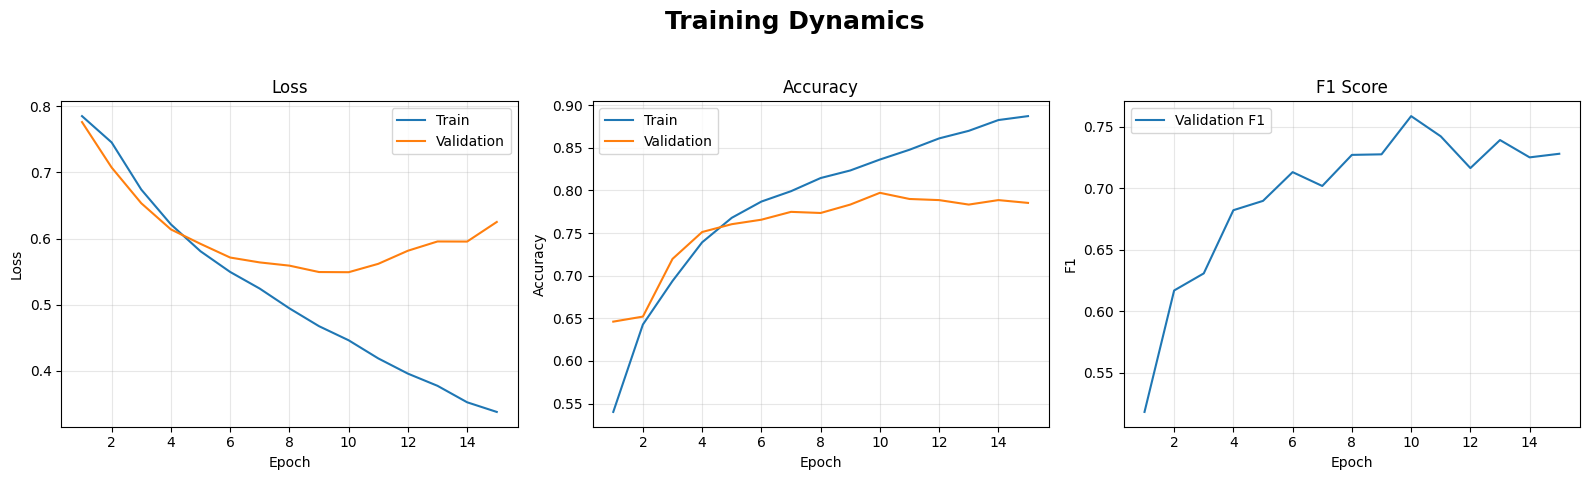

In [1509]:
plot_training_history(history, save_path=cfg.IMAGE_DIR)

In [1510]:
save_history_path = os.path.join(cfg.ARTIFACT_DIR, "training_history.json")
history.save(save_history_path)

Training history saved to artifacts\training_history.json


In [1369]:
model = DisasterTwittsClassifier(
    vocab_size=vocab_size,
    emb_dim=cfg.EMB_DIM,
    hidden_dim=cfg.HIDDEN_DIM,
    output_dim=cfg.OUTPUT_DIM,
    num_layers=cfg.NUM_LSTM_LAYERS,
    dropout=cfg.DROPOUT,
    bidirectional=True,
    embedding=embedding,
    freeze_embedding=False,
).to(cfg.DEVICE)
# Initial optimizer with embeddings frozen
optimizer = optim.Adam([
    {"params": model.lstm.parameters()},
    {"params": model.fc.parameters()}
], lr=cfg.LEARNING_RATE)

early_stopper = EarlyStopping(
    patience=cfg.EARLY_STOP_PATIENCE,
    mode='max',
    min_delta=cfg.EARLY_STOP_MIN_DELTA
)

In [1370]:
print("Unfreezing Embedding layer from epoch 5")
for epoch in range (cfg.EPOCHS):
    print(f"Epoch {epoch+1}")
    train_loss, train_results = train_one_epoch(
        model=model,
        loader=train_dl,
        criterion=criterion,
        optimizer=optimizer,
        metrics=train_metrics,
        device=cfg.DEVICE
    )
    val_loss, val_results = evaluate(
        model=model,
        loader=val_dl,
        criterion=criterion,
        metrics=val_metrics,
        device=cfg.DEVICE
    )

    if epoch == cfg.EPOCHS // 10:
        model.embedding.weight.requires_grad = True
        print("Embedding Unfrozen !")
        # Redefine optimizer to include embeddings with smaller LR
        optimizer = optim.Adam([
            {"params": model.embedding.parameters(), "lr": cfg.LEARNING_RATE / 10},
            {"params": model.lstm.parameters()},
            {"params": model.fc.parameters()}
        ], lr=cfg.LEARNING_RATE)
    
    current_f1 = val_results["f1"]
    
    print(
        f"Train results:\n\tLoss --> {train_loss:.4f} | "
        f"Accuracy --> {train_results['accuracy']:.4f}\n"
    )
    print(
        f"Validation results:\n\tLoss --> {val_loss:.4f} | "
        f"Accuracy --> {val_results['accuracy']:.4f}\n"
        f"\tPrecision --> {val_results['precision']:.4f} | "
        f"Recall --> {val_results['recall']:.4f} | "
        f"F1 --> {val_results['f1']:.4f}\n"
    )

    improved = early_stopper.step(current_f1)

    if improved:
        checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "best_f1": current_f1,
        "config": Config.to_dict(),
        "vocab": vocab
    }

        torch.save(checkpoint, os.path.join(cfg.CHECKPOINT_PATH, "best_model_unfreeze_emb.pt"))
        print("Model best Checkpoint saved...")

    if early_stopper.should_stop:
        print(f"Early Stop triggered at Epoch {epoch + 1}")
        break
    print("="*180)

Unfreezing Embedding layer from epoch 5
Epoch 1
Train results:
	Loss --> 0.7865 | Accuracy --> 0.5608

Validation results:
	Loss --> 0.7789 | Accuracy --> 0.5384
	Precision --> 0.4779 | Recall --> 0.8648 | F1 --> 0.6156

Model best Checkpoint saved...
Epoch 2
Train results:
	Loss --> 0.7546 | Accuracy --> 0.6268

Validation results:
	Loss --> 0.7140 | Accuracy --> 0.6776
	Precision --> 0.6739 | Recall --> 0.4762 | F1 --> 0.5581

Epoch 3
Train results:
	Loss --> 0.6672 | Accuracy --> 0.7005

Validation results:
	Loss --> 0.6443 | Accuracy --> 0.7216
	Precision --> 0.7067 | Recall --> 0.5960 | F1 --> 0.6467

Model best Checkpoint saved...
Epoch 4
Train results:
	Loss --> 0.6113 | Accuracy --> 0.7422

Validation results:
	Loss --> 0.6100 | Accuracy --> 0.7518
	Precision --> 0.7561 | Recall --> 0.6190 | F1 --> 0.6807

Model best Checkpoint saved...
Epoch 5
Train results:
	Loss --> 0.5746 | Accuracy --> 0.7665

Validation results:
	Loss --> 0.5807 | Accuracy --> 0.7676
	Precision --> 0.7647

In [1511]:
checkpoint = torch.load(os.path.join(cfg.CHECKPOINT_PATH, "best_model_freeze_emb.pt"))
model = DisasterTwittsClassifier(
    vocab_size=len(checkpoint["vocab"]),
    emb_dim=checkpoint["config"]["EMB_DIM"],
    hidden_dim=checkpoint["config"]["HIDDEN_DIM"],
    output_dim=checkpoint["config"]["OUTPUT_DIM"],
    num_layers=checkpoint["config"]["NUM_LSTM_LAYERS"],
    dropout=checkpoint["config"]["DROPOUT"],
    bidirectional=True,
    embedding=None,          # IMPORTANT
    freeze_embedding=True
).to(cfg.DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])

print("Model Checkpoint loaded successfully !")

Model Checkpoint loaded successfully !


In [1512]:
@torch.no_grad()
def find_best_threshold(
    model,
    loader,
    t_min=0.1,
    t_max=0.9,
    steps=81,
    device=cfg.DEVICE
):
    model.eval()

    all_probs = []
    all_labels = []

    for batch in loader:
        inputs = batch["input_ids"].to(device)
        labels = batch["labels"].cpu()

        logits = model(inputs)
        probs = torch.sigmoid(logits).cpu()

        all_probs.append(probs)
        all_labels.append(labels)

    probs = torch.cat(all_probs)
    labels = torch.cat(all_labels)

    best_f1 = 0.0
    best_t = 0.5

    for t in torch.linspace(t_min, t_max, steps=steps):
        preds = (probs >= t).int()
        f1 = f1_score(labels, preds)

        if f1 > best_f1:
            best_f1 = f1
            best_t = t.item()

    return best_f1, best_t


In [1513]:
best_f1, best_t = find_best_threshold(model, val_dl)
print(
    "Post Processing Step --> Fine-Tuning F1 Threshold\n"
    f"Best F1: {best_f1} | Best Threshold: {best_t}"
)
cfg.INFERENCE_THRESHOLD = best_t
torch.save(cfg.INFERENCE_THRESHOLD, os.path.join(cfg.CHECKPOINT_PATH, "best_threshold.pt"))
print("Best Threshold saved successfully !")

Post Processing Step --> Fine-Tuning F1 Threshold
Best F1: 0.760852407261247 | Best Threshold: 0.5199999809265137
Best Threshold saved successfully !


In [1514]:
def save_config(config_cls, path: str):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)

    config_dict = config_cls.to_dict()

    # YAML safety: convert Paths to strings
    for k, v in config_dict.items():
        if isinstance(v, (Path, torch.device)):
            config_dict[k] = str(v)

    with open(path, "w", encoding="utf-8") as f:
        yaml.safe_dump(
            config_dict,
            f,
            sort_keys=False,
            default_flow_style=False
        )

    print("Config saved as YAML file successfully !")

In [1515]:
save_config_path = os.path.join(cfg.ARTIFACT_DIR, "config.yaml")
save_config(config_cls=cfg, path=save_config_path)

Config saved as YAML file successfully !
